## Objetivo
El objetivo del análisis es crear un modelo de regresión que pueda predecir la calificación de una película o serie según el título, año de creación, duración, actores principales y descripción.

En primer lugar, importamos las bibliotecas que vamos a utilizar

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

### Análisis de los datos
Trabajaremos con el dataset IMDB, pero primero tenemos que analizar qué datos tiene y cuáles nos sirven.

## Exploración y procesamiento del conjunto de datos

In [2]:
dataset = pd.read_csv('/content/IMBD.csv')
df = pd.DataFrame(dataset)
print('Primeras filas:')
df.head()

Primeras filas:


,title,year,certificate,duration,genre,rating,description,stars,votes
0,Cobra Kai,(2018– ),TV-14,30 min,"Action, Comedy, Drama",8.5,Decades after their 1984 All Valley Karate Tou...,"['Ralph Macchio, ', 'William Zabka, ', 'Courtn...","177,031"
1,The Crown,(2016– ),TV-MA,58 min,"Biography, Drama, History",8.7,Follows the political rivalries and romance of...,"['Claire Foy, ', 'Olivia Colman, ', 'Imelda St...","199,885"
2,Better Call Saul,(2015–2022),TV-MA,46 min,"Crime, Drama",8.9,The trials and tribulations of criminal lawyer...,"['Bob Odenkirk, ', 'Rhea Seehorn, ', 'Jonathan...","501,384"
3,Devil in Ohio,(2022),TV-MA,356 min,"Drama, Horror, Mystery",5.9,When a psychiatrist shelters a mysterious cult...,"['Emily Deschanel, ', 'Sam Jaeger, ', 'Gerardo...","9,773"
4,Cyberpunk: Edgerunners,(2022– ),TV-MA,24 min,"Animation, Action, Adventure",8.6,A Street Kid trying to survive in a technology...,"['Zach Aguilar, ', 'Kenichiro Ohashi, ', 'Emi ...","15,413"


In [3]:
print('Las columnas son :\n')
print(f'{df.columns}\n')

print(f'La forma completa del dataset es: {df.shape}')

Las columnas son :

Index(['title', 'year', 'certificate', 'duration', 'genre', 'rating',
       'description', 'stars', 'votes'],
      dtype='object')

La forma completa del dataset es: (9957, 9)


Vemos que tenemos las siguientes columnas:
- **Título** de la película o serie
- **Año** de estreno
- **Certificado**
- **Géneros**
- **Rating**
- **Descripción**
- **Actores principales**
- **Votos**

Analizamos qué datos tenemos en cada columna, y cuáles pueden llegar a ser nulos o vacíos.

In [4]:
df.describe(include='all')

,title,year,certificate,duration,genre,rating,description,stars,votes
count,9957,9430,6504,7921,9884,8784.000000,9957,9957,8784
unique,7912,498,20,291,569,NaN,9433,8615,4862
top,Top Gear,(2020),TV-MA,60 min,Comedy,NaN,Add a Plot,[],30
freq,92,663,2520,385,859,NaN,434,403,33
mean,NaN,NaN,NaN,NaN,NaN,6.764515,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,1.214840,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,1.700000,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,6.100000,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,6.900000,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,7.600000,NaN,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9957 entries, 0 to 9956
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        9957 non-null   object 
 1   year         9430 non-null   object 
 2   certificate  6504 non-null   object 
 3   duration     7921 non-null   object 
 4   genre        9884 non-null   object 
 5   rating       8784 non-null   float64
 6   description  9957 non-null   object 
 7   stars        9957 non-null   object 
 8   votes        8784 non-null   object 
dtypes: float64(1), object(8)
memory usage: 700.2+ KB


Vemos que hay varias columnas que tienen muchos datos nulos, particularmente certificado, duración, rating y votos. Como para el modelo que queremos armar, las features *certificado* y *votos* no son datos que van a darnos información relevante, las quitamos del dataframe.
Luego, como *rating* y *descripción* son los datos que más nos van a ayudar, quitamos las filas donde esas columnas tienen datos nulos. Si bien perdemos algunas filas, nos va a ayudar a entrenar mejor al modelo.

In [6]:
df = df.drop(columns=['certificate', 'votes'])
df = df.dropna(subset=['rating', 'description'])

In [7]:
print('El nuevo dataset tiene:\n')
print(f'Columnas: {df.columns}\n')

print(f'Filas y columnas: {df.shape}')

El nuevo dataset tiene:

Columnas: Index(['title', 'year', 'duration', 'genre', 'rating', 'description', 'stars'], dtype='object')

Filas y columnas: (8784, 7)


## Análisis del objetivo

Como el rating es el dato que vamos a querer predecir, lo analizamos con más detalle.

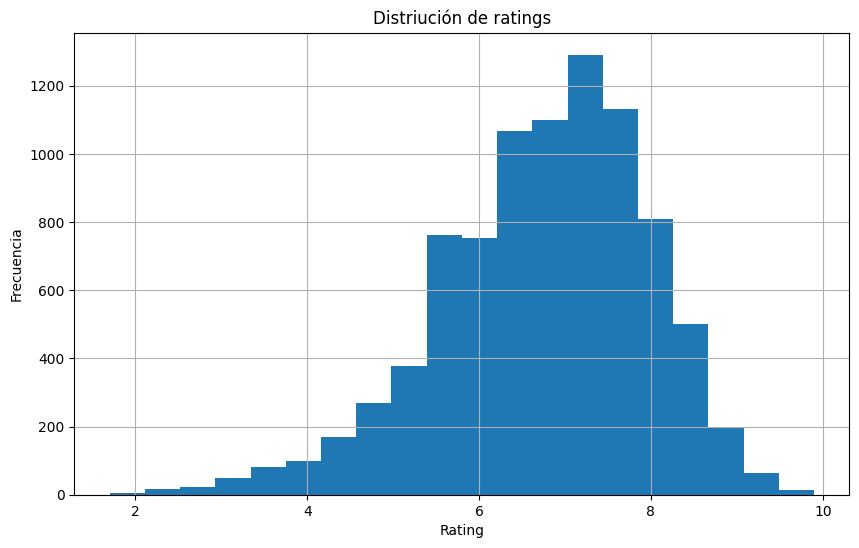

In [8]:
plt.figure(figsize=(10,6))
df['rating'].hist(bins=20)
plt.title('Distriución de ratings')
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
avg_rating_by_genre = df.explode('genre').groupby('genre')['rating'].mean().sort_values()
print("\nRating promedio según género:")
print(avg_rating_by_genre)


Rating promedio según género:
genre
Action, Mystery, Sci-Fi          2.600000
Drama, Family, Reality-TV        2.800000
Crime, Horror, Romance           3.000000
Fantasy, Horror, Thriller        3.450000
Action, Romance                  3.700000
                                   ...   
Action, Game-Show, Reality-TV    8.211765
Comedy, News, Talk-Show          8.300000
Documentary, Short, Sci-Fi       8.500000
Family, Talk-Show                8.700000
Drama, History, Horror           9.600000
Name: rating, Length: 546, dtype: float64


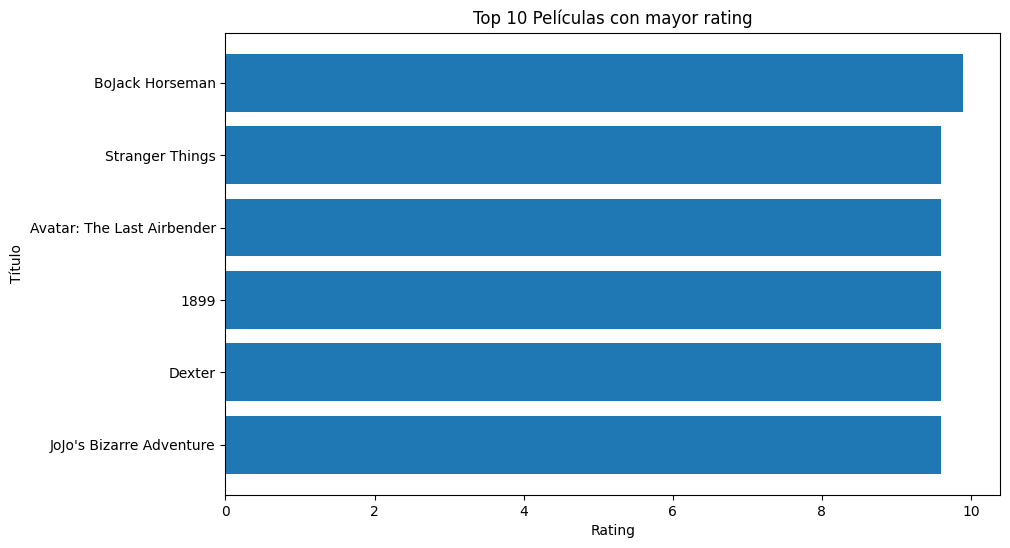

                           title  rating
9444             BoJack Horseman     9.9
9578             Stranger Things     9.6
8161  Avatar: The Last Airbender     9.6
17                          1899     9.6
8259                      Dexter     9.6
8557    JoJo's Bizarre Adventure     9.6
8907  Avatar: The Last Airbender     9.6
8044  Avatar: The Last Airbender     9.5
9445             BoJack Horseman     9.5
9586  Avatar: The Last Airbender     9.5


In [10]:
top_rated_movies = df.sort_values(by='rating', ascending=False)

top_10_rated_movies = top_rated_movies.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_rated_movies['title'], top_10_rated_movies['rating'])
plt.gca().invert_yaxis()
plt.title('Top 10 Películas con mayor rating')
plt.xlabel('Rating')
plt.ylabel('Título')
plt.show()

print(top_10_rated_movies[['title', 'rating']])

### Correlación del objetivo con las demás variables

Hacemos un análisis un poco más profundo para entender is existe alguna correlación entre el rating de las películas por el año en el que fueron publicadas.

<Axes: title={'center': 'Rating promedio por año'}, xlabel='year'>

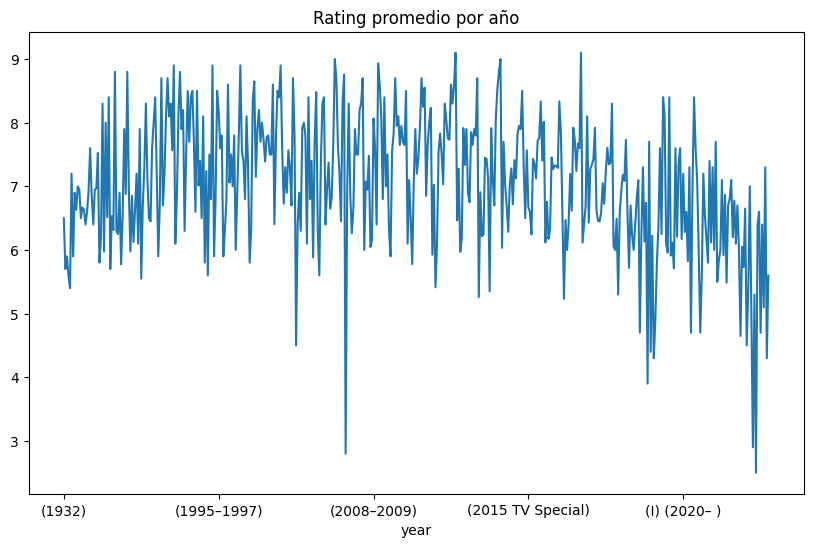

In [11]:
df.groupby('year')['rating'].mean().plot(figsize=(10,6), title='Rating promedio por año')


Además, analizamos si la duración de la película afecta al rating de la misma. Observamos los casos particulares de los outliers con películas de larga duración.

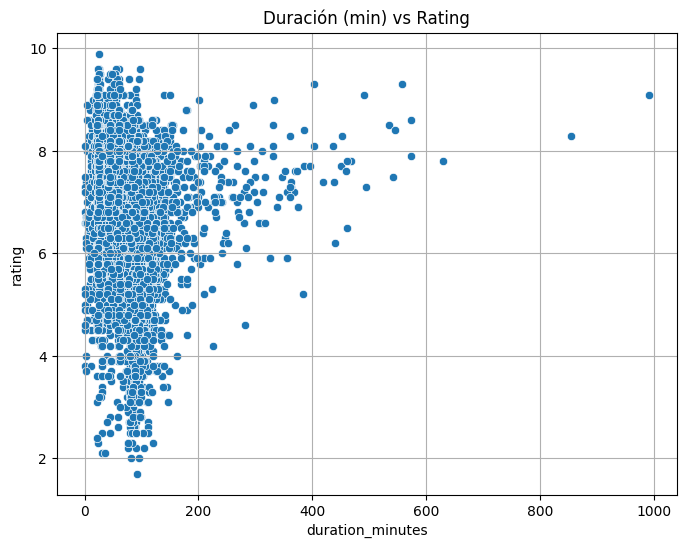

In [12]:
df['duration_minutes'] = df['duration'].str.extract('(\d+)').astype(float)

plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='duration_minutes', y='rating')
plt.title('Duración (min) vs Rating')
plt.grid(True)
plt.show()

Para lograr graficar el rating por género, teniendo en cuenta que en nuestro dataset los géneros si son más de uno se encuentran como listas de strings y si es uno solo, se encuentra en una cadena (sin estar dentro de una lista), unificaremos el tipo de dato en esa feature, transformando a una cadena en cualquier caso.

In [13]:
def parse_genres(x):
    if isinstance(x, list):
        sep = ","
        return sep.join(list)
    elif isinstance(x, str):
        return x
    return ""

df['genre'] = df['genre'].apply(parse_genres)
df_exploded = df.explode('genre').reset_index(drop=True)

Ahora, generaremos el gráfico y observaremos el rating por género.

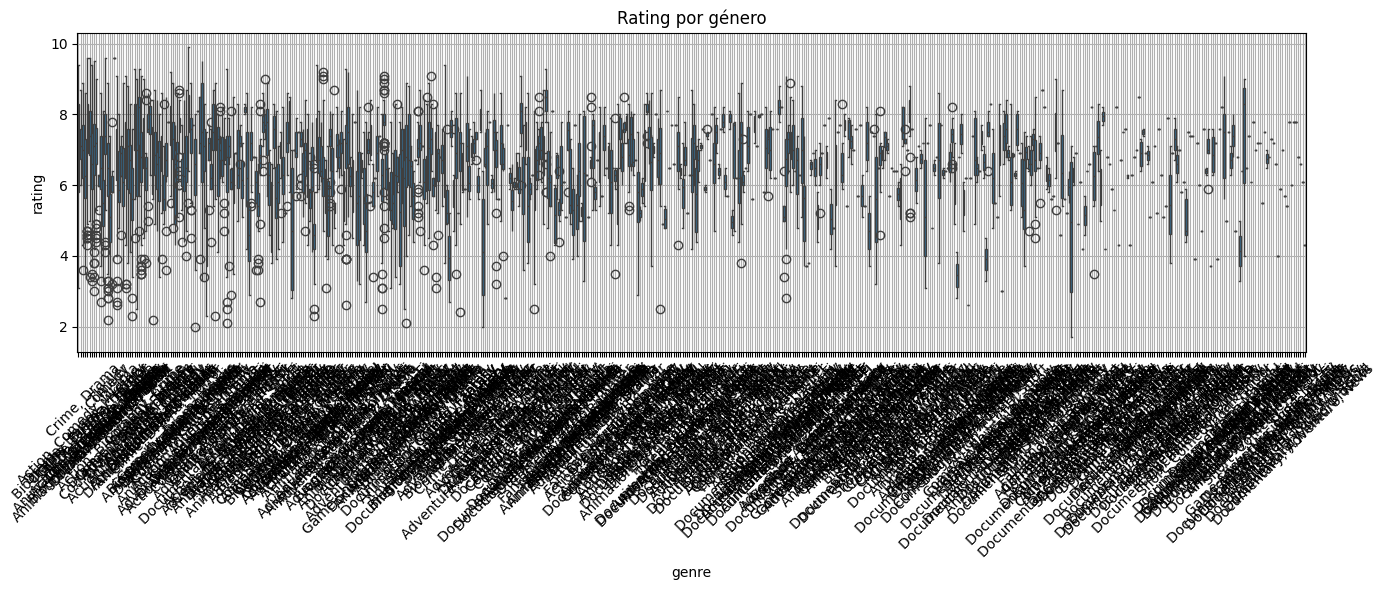

In [14]:
plt.figure(figsize=(14,6))
sns.boxplot(data=df_exploded, x='genre', y='rating')
plt.xticks(rotation=45)
plt.title('Rating por género')
plt.grid(True)
plt.tight_layout()
plt.show()

## Modelos
Una vez hecho el análisis de los datos, podemos armar el modelo para predecir los ratings. Vamos a usar PyCaret que nos permite usar AutoML.

In [15]:
!pip install pycaret[full]

In [16]:
import pycaret
from pycaret.regression import *

# El setup inicializa el ambiente de training y crea el pipeline de transformación
s = setup(df, target = 'rating', session_id=123, memory=False)

,Description,Value
0,Session id,123
1,Target,rating
2,Target type,Regression
3,Original data shape,"(8784, 8)"
4,Transformed data shape,"(8784, 8)"
5,Transformed train set shape,"(6148, 8)"
6,Transformed test set shape,"(2636, 8)"
7,Numeric features,1
8,Categorical features,6
9,Rows with missing values,12.6%


Usamos la función `compare_models` de PyCaret que entrena y evalúa distintos estimadores para saber cuál es el mejor para nuestro problema.  

In [17]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,0.8025,1.1484,1.0711,0.2433,0.1573,0.1415,0.3170
ada,AdaBoost Regressor,0.8711,1.2946,1.1373,0.1466,0.1653,0.1510,0.5750
ridge,Ridge Regression,0.8993,1.3738,1.1716,0.0946,0.1701,0.1569,0.5030
lr,Linear Regression,0.9005,1.3778,1.1732,0.0920,0.1702,0.1571,1.6870
br,Bayesian Ridge,0.9005,1.3777,1.1732,0.0920,0.1702,0.1571,0.1860
lar,Least Angle Regression,0.9155,1.4174,1.1898,0.0663,0.1723,0.1595,0.3000
gbr,Gradient Boosting Regressor,0.9166,1.4165,1.1897,0.0661,0.1722,0.1597,0.6590
huber,Huber Regressor,0.8885,1.4223,1.1906,0.0636,0.1689,0.1545,0.2650
xgboost,Extreme Gradient Boosting,0.9307,1.4288,1.1948,0.0579,0.1719,0.1600,0.3720
et,Extra Trees Regressor,0.9300,1.4303,1.1955,0.0572,0.1725,0.1610,0.5310


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

A partir de esos resultados, vemos que los mejores son:

- CatBoost Regressor
- AdaBoost Regressor
- KNN

### Catboost Regressor

In [18]:
m = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9477,1.4970,1.2235,0.0401,0.1762,0.1646
1,0.8974,1.4002,1.1833,0.0331,0.1724,0.1582
2,0.9604,1.5294,1.2367,0.0391,0.1803,0.1696
3,0.9118,1.4214,1.1922,0.0385,0.1713,0.1578
4,0.9418,1.4253,1.1939,0.0422,0.1697,0.1598
5,0.9704,1.5247,1.2348,0.0365,0.1773,0.1676
6,0.9332,1.3810,1.1752,0.0143,0.1621,0.1516
7,0.9921,1.6014,1.2655,0.0368,0.1853,0.1753
8,0.9131,1.3597,1.1661,0.0188,0.1671,0.1559


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluamos y guardamos los resultados del modelo base

In [19]:
evaluate_model(m)
catboost_base_results = pull().copy()

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Ajustamos el modelo base

In [20]:
tuned_model_catboost = tune_model(m)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8843,1.3908,1.1793,0.1082,0.1725,0.1577
1,0.8713,1.3504,1.1621,0.0676,0.1706,0.1554
2,0.8850,1.4123,1.1884,0.1126,0.1761,0.1611
3,0.8589,1.3168,1.1475,0.1092,0.1674,0.1518
4,0.9122,1.3898,1.1789,0.0661,0.1688,0.1573
5,0.9250,1.5064,1.2274,0.0481,0.1784,0.1652
6,0.8677,1.2796,1.1312,0.0867,0.1584,0.1450
7,0.9291,1.5141,1.2305,0.0893,0.1830,0.1691
8,0.8287,1.2186,1.1039,0.1206,0.1615,0.1462


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Evaluamos y guardamos los resultados del modelo ajustado

In [21]:
evaluate_model(tuned_model_catboost)
catboost_tuned_results = pull().copy()

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Comparamos ambos resultados, modelo base y ajustado

In [22]:
comparacion_catboost = pd.DataFrame({
    'Modelo': ['catboost base', 'catboost tuned'],
    'MAE': [
        catboost_base_results.loc['Mean', 'MAE'],
        catboost_tuned_results.loc['Mean', 'MAE']
    ],
    'RMSE': [
        catboost_base_results.loc['Mean', 'RMSE'],
        catboost_tuned_results.loc['Mean', 'RMSE']
    ],
    'R2': [
        catboost_base_results.loc['Mean', 'R2'],
        catboost_tuned_results.loc['Mean', 'R2']
    ]
})

print("Comparación de catboost base vs tunado:")
print(comparacion_catboost)

Comparación de catboost base vs tunado:
           Modelo     MAE    RMSE     R2
0   catboost base  0.9444  1.2126  0.030
1  catboost tuned  0.8877  1.1765  0.087


### AdaBoost Regressor

Probamos el modelo de AdaBoost Regressor

In [23]:
a = create_model('ada')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8592,1.2915,1.1364,0.1719,0.1658,0.1500
1,0.8508,1.2557,1.1206,0.1329,0.1639,0.1489
2,0.9262,1.4060,1.1857,0.1166,0.1720,0.1590
3,0.8318,1.1915,1.0915,0.1940,0.1584,0.1424
4,0.8690,1.2750,1.1292,0.1432,0.1622,0.1489
5,0.8963,1.3398,1.1575,0.1533,0.1678,0.1551
6,0.8450,1.2053,1.0979,0.1397,0.1534,0.1394
7,0.9156,1.4082,1.1867,0.1530,0.1755,0.1621
8,0.8392,1.2168,1.1031,0.1219,0.1607,0.1463


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluamos y guardamos los resultados del modelo base

In [24]:
evaluate_model(a)
ada_base_results = pull().copy()

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Ajustamos el modelo base

In [25]:
tuned_model_ada = tune_model(a)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8665,1.2814,1.1320,0.1784,0.1643,0.1491
1,0.8350,1.2124,1.1011,0.1628,0.1613,0.1459
2,0.9034,1.3475,1.1608,0.1534,0.1698,0.1569
3,0.8428,1.2065,1.0984,0.1839,0.1591,0.1438
4,0.8713,1.2513,1.1186,0.1592,0.1601,0.1472
5,0.9059,1.3644,1.1681,0.1378,0.1692,0.1568
6,0.8403,1.2001,1.0955,0.1434,0.1534,0.1392
7,0.8928,1.3828,1.1759,0.1683,0.1752,0.1607
8,0.8535,1.2609,1.1229,0.0901,0.1635,0.1498


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Evaluamos y guardamos los resultados del modelo ajustado

In [26]:
evaluate_model(tuned_model_ada)
ada_tuned_results = pull().copy()

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Comparamos los resultados del modelo base y el modelo ajustado

In [27]:
comparacion_adaboost = pd.DataFrame({
    'Modelo': ['adaboost base', 'adaboost tuned'],
    'MAE': [
        ada_base_results.loc['Mean', 'MAE'],
        ada_tuned_results.loc['Mean', 'MAE']
    ],
    'RMSE': [
        ada_base_results.loc['Mean', 'RMSE'],
        ada_tuned_results.loc['Mean', 'RMSE']
    ],
    'R2': [
        ada_base_results.loc['Mean', 'R2'],
        ada_tuned_results.loc['Mean', 'R2']
    ]
})

print("Comparación de adaboost base vs tunado:")
print(comparacion_adaboost)

Comparación de adaboost base vs tunado:
           Modelo     MAE    RMSE      R2
0   adaboost base  0.8711  1.1373  0.1466
1  adaboost tuned  0.8704  1.1347  0.1502


### KNN

In [28]:
 k = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7869,1.1336,1.0647,0.2731,0.1572,0.1403
1,0.7717,1.0819,1.0401,0.2530,0.1533,0.1367
2,0.8186,1.2181,1.1037,0.2347,0.1639,0.1478
3,0.7864,1.0759,1.0373,0.2722,0.1516,0.1370
4,0.8153,1.1248,1.0605,0.2442,0.1525,0.1394
5,0.8317,1.2219,1.1054,0.2278,0.1617,0.1463
6,0.7598,1.0371,1.0184,0.2598,0.1442,0.1280
7,0.8586,1.2756,1.1294,0.2328,0.1692,0.1551
8,0.7830,1.0941,1.0460,0.2104,0.1526,0.1361


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluamos y guardamos los resultados del modelo base

In [29]:
evaluate_model(k)
knn_base_results = pull().copy()

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [30]:
tuned_model_knn = tune_model(k)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7664,1.0712,1.0350,0.3131,0.1531,0.1357
1,0.7541,1.0499,1.0246,0.2751,0.1526,0.1347
2,0.7799,1.0649,1.0319,0.3309,0.1545,0.1395
3,0.7460,0.9863,0.9931,0.3328,0.1465,0.1303
4,0.7704,1.0183,1.0091,0.3157,0.1465,0.1323
5,0.8195,1.1787,1.0857,0.2552,0.1590,0.1436
6,0.7183,0.9199,0.9591,0.3435,0.1366,0.1207
7,0.8130,1.1801,1.0863,0.2902,0.1642,0.1474
8,0.7544,1.0343,1.0170,0.2536,0.1487,0.1312


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Evaluamos y guardamos los resultados del modelo ajustado

In [31]:
evaluate_model(tuned_model_knn)
knn_tuned_results = pull().copy()

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Comparamos los resultados del modelo base y el modelo ajsutado

In [32]:
comparacion_knn = pd.DataFrame({
    'Modelo': ['KNN base', 'KNN tuned'],
    'MAE': [
        knn_base_results.loc['Mean', 'MAE'],
        knn_tuned_results.loc['Mean', 'MAE']
    ],
    'RMSE': [
        knn_base_results.loc['Mean', 'RMSE'],
        knn_tuned_results.loc['Mean', 'RMSE']
    ],
    'R2': [
        knn_base_results.loc['Mean', 'R2'],
        knn_tuned_results.loc['Mean', 'R2']
    ]
})

print("Comparación de KNN base vs tunado:")
print(comparacion_knn)

Comparación de KNN base vs tunado:
      Modelo     MAE    RMSE      R2
0   KNN base  0.8025  1.0711  0.2433
1  KNN tuned  0.7711  1.0310  0.2986


Podemos observar que los resultados son iguales entre ambos modelos

## Comparamos resultados de Catboost, Adaboost y KNN

Comparación final de modelos ajustados:

              Modelo     MAE    RMSE      R2
0  CatBoost Ajustado  0.8877  1.1765  0.0870
1  AdaBoost Ajustado  0.8704  1.1347  0.1502
2       KNN Ajustado  0.7711  1.0310  0.2986


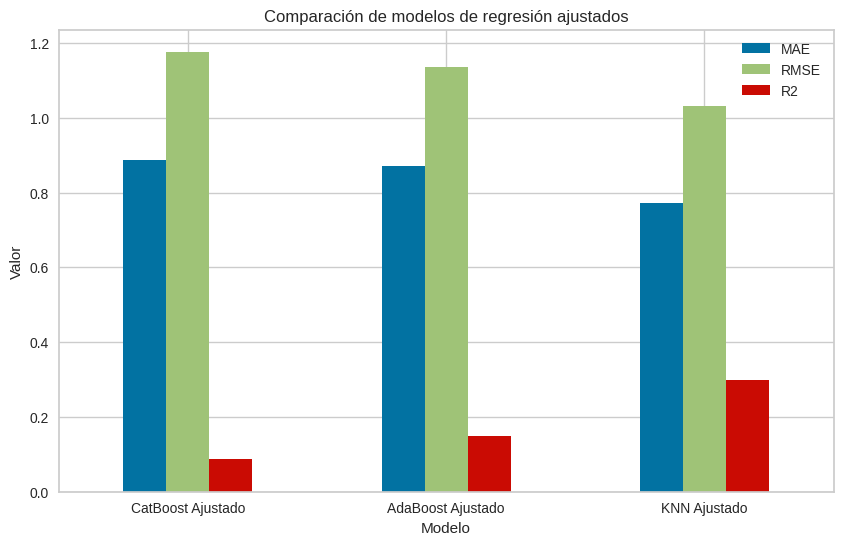

In [33]:
comparacion_modelos = pd.DataFrame({
    'Modelo': ['CatBoost Ajustado', 'AdaBoost Ajustado', 'KNN Ajustado'],
    'MAE': [
        catboost_tuned_results.loc['Mean', 'MAE'],
        ada_tuned_results.loc['Mean', 'MAE'],
        knn_tuned_results.loc['Mean', 'MAE']
    ],
    'RMSE': [
        catboost_tuned_results.loc['Mean', 'RMSE'],
        ada_tuned_results.loc['Mean', 'RMSE'],
        knn_tuned_results.loc['Mean', 'RMSE']
    ],
    'R2': [
        catboost_tuned_results.loc['Mean', 'R2'],
        ada_tuned_results.loc['Mean', 'R2'],
        knn_tuned_results.loc['Mean', 'R2']
    ]
})

# Mostrar tabla
print("Comparación final de modelos ajustados:\n")
print(comparacion_modelos)

# Visualizar
comparacion_modelos.set_index('Modelo')[['MAE', 'RMSE', 'R2']].plot(kind='bar', figsize=(10,6))
plt.title('Comparación de modelos de regresión ajustados')
plt.ylabel('Valor')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

Por los resultados expresados podemos conlcuir que el mejor modelo es KNN ya que tiene un menor MAE (menor error promedio absoluto), menor RMSE (menores errores generales) y mayor R2 que los demás modelos.

## Descargamos el mejor modelo
Concluimos que el mejor modelo para este caso es KNN. Descargamos el modelo.

In [34]:
final_model = finalize_model(tuned_model_knn)
save_model(final_model, 'knn_tuned_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['duration_minutes'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['title', 'year', 'duration',
                                              'genre', 'description', 'stars'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('rest_encoding',
                  TransformerWrapper(include=['title', 'year', 'duration',
                                              'genre', 'description', 'stars'],
                                     transformer=TargetEncoder(cols=['title',
                                                                     'year',
                                                                     'duration',
                                                                     'ge

Descargamos el modelo para poder utilizarlo en nuestro aplicación

In [35]:
from google.colab import files
files.download('knn_tuned_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>